<a href="https://colab.research.google.com/github/Noam2710/StyleGAN_Interpolation/blob/master/Copy_of_style_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [32]:
!git clone https://github.com/NVlabs/stylegan.git

fatal: destination path 'stylegan' already exists and is not an empty directory.


In [0]:
import sys
sys.path.insert(0, "/content/stylegan")

import dnnlib
import os
import pickle
import numpy as np
import PIL.Image
import dnnlib.tflib as tflib
import config
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import cv2
from matplotlib import pyplot as plt
import pickle
list_of_models = ['vgg16']
model_to_color = {'vgg16':'b','resnet50':'r','senet50':'g'}
list_of_algo = ['OpenAI']
algo_to_color = {'OpenAI':'b','CMA-ES':'r','RandomSearch':'g'}
fps_in_video = 5
image_size_in_video = (600,600)
es_learning_rate = 0.1
es_sigma = 0.5
save_images = False
rnd = np.random.RandomState(seed=5)

In [0]:
tflib.init_tf()
with open('/content/drive/My Drive/karras2019stylegan-ffhq-1024x1024.pkl', "rb") as f:
  _G, _D, Gs = pickle.load(f)

Source image


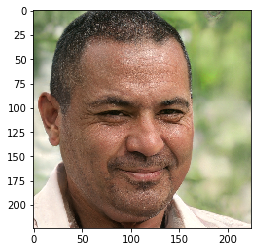

Destination image


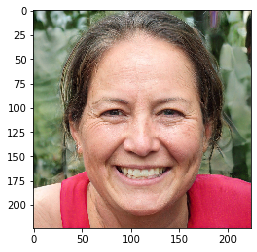

In [35]:
latents = rnd.randn(2, Gs.input_shape[1])
dest_latent = latents[1,np.newaxis]
source_latent = latents[0,np.newaxis]
fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
source_image = np.squeeze(Gs.run(source_latent, None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt))
dest_image = np.squeeze(Gs.run(dest_latent, None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt))
print("Source image")
source_res = cv2.resize(np.squeeze(source_image), dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
plt.imshow(source_res)
plt.show()
print("Destination image")
dest_res = cv2.resize(np.squeeze(dest_image), dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
plt.imshow(dest_res)
plt.show()

In [36]:
!pip install evostra
from evostra import EvolutionStrategy

In [37]:
pip install keras_vggface

In [0]:
from keras.engine import  Model
from keras.layers import Flatten, Dense, Input
from keras_vggface.vggface import VGGFace
from keras_vggface import utils
from keras.preprocessing import image
from datetime import datetime

def predict_features_from_image(res):
  res = image.img_to_array(res)
  res = np.expand_dims(res, axis=0)
  res = utils.preprocess_input(res, version=2) # or version=2
  return vgg_features.predict(res)

In [0]:
def get_reward_by_vgg(latent_vector):
  image_to_check = np.squeeze(Gs.run(latent_vector[0], None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt))
  image_after_resize = cv2.resize(image_to_check, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
  image_to_check_features = predict_features_from_image(image_after_resize)
  return -np.linalg.norm(image_to_check_features - features_of_dest_images)

def get_rewared_by_vgg_cosine(latent_vector):
  image_to_check = np.squeeze(Gs.run(latent_vector[0], None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt))
  image_after_resize = cv2.resize(image_to_check, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
  image_to_check_features = predict_features_from_image(image_after_resize)
  return cosine_similarity(np.squeeze(image_to_check_features),np.squeeze(features_of_dest_images))*50

def cosine_similarity(x, y):
    return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))

In [0]:
def run_es_model(verbose=False,run_each_time=2,total_runs=600,save_images=False):
  global features_of_dest_images
  features_of_dest_images = predict_features_from_image(dest_res)
  init_latent_vector = [source_latent]
  source_image = Gs.run(source_latent, None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt)
  res = cv2.resize(np.squeeze(source_image), dsize=image_size_in_video, interpolation=cv2.INTER_CUBIC)
  list_of_images = [cv2.cvtColor(res, cv2.COLOR_BGR2RGB)]
  list_of_rewards = []
  es = EvolutionStrategy(init_latent_vector, get_reward_by_vgg, population_size=50, sigma=es_sigma, learning_rate=es_learning_rate, num_threads=1)
  for i in range (int(total_runs/run_each_time)):
    print("Iterations {} - {} | Reward {}".format(i*run_each_time,(i+1)*run_each_time,es.get_reward(es.get_weights())))
    es.run(run_each_time,print_step=run_each_time*10000)
    list_of_rewards.append(es.get_reward(es.get_weights()))
    images = Gs.run(es.get_weights()[0], None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt)
    res = cv2.resize(np.squeeze(images), dsize=image_size_in_video, interpolation=cv2.INTER_CUBIC)
    if verbose:
      plt.imshow(res)
      plt.show()
    if save_images:
      list_of_images.append(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
  return list_of_images,list_of_rewards

In [0]:
def export_list_to_pickle(network_name):
  for algo in list_of_algo:
    with open('./logs/{}--{}.pkl'.format(algo,es_learning_rate), 'wb') as f:
      pickle.dump(model_to_rewards[network_name][algo], f)

def print_graphs_for_feature_extraction_network(network_name):
  for algo in list_of_algo:
    plt.plot(list(range(1,len(model_to_rewards[network_name][algo])+1)),model_to_rewards[network_name][algo], algo_to_color[algo], label=algo)
  plt.title(network_name)
  plt.legend()
  plt.show()

In [0]:
def list_of_images_to_video(image_list,model_name,algo,date_time):  
  out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'mp4v'), fps_in_video, image_size_in_video)
  for i in range(len(images_list)):
      out.write(images_list[i])
  out.release()

  !mv 'project.avi' '/content/drive/My Drive/videos_of_transformation'
  os.rename('/content/drive/My Drive/videos_of_transformation/project.avi', '/content/drive/My Drive/videos_of_transformation/{}-{}--{}.avi'.format(model_name,algo,date_time))

In [43]:
global es_learning_rate
global es_sigma
for sig in [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7]:
  print("checking sigma " + str(sig))
  es_sigma = sig
  model_to_rewards = {}
  features_of_dest_images = None
  for model in list_of_models:
    model_to_rewards[model] = {}
    for algo in list_of_algo:
      now = datetime.now() # current date and time
      date_time = now.strftime("%m-%d-%Y-%H-%M-%S")
      vgg_features = VGGFace(model=model, include_top=False, input_shape=(224, 224, 3), pooling='avg')
      if algo == 'OpenAI':
        images_list,reward_list = run_es_model(verbose=False,run_each_time=2,total_runs=600,save_images=save_images)

      if save_images:
        list_of_images_to_video(images_list,model,algo,date_time)
      model_to_rewards[model][algo] = reward_list

    export_list_to_pickle(model)

Iterations 0 - 2 | Reward -108.50316619873047
Iterations 2 - 4 | Reward -105.9817123413086
Iterations 4 - 6 | Reward -120.55707550048828
Iterations 6 - 8 | Reward -117.4115219116211
Iterations 8 - 10 | Reward -105.17406463623047
Iterations 10 - 12 | Reward -101.9468002319336
Iterations 12 - 14 | Reward -93.60801696777344
Iterations 14 - 16 | Reward -84.79839324951172
Iterations 16 - 18 | Reward -93.24185943603516
Iterations 18 - 20 | Reward -89.2168197631836
Iterations 20 - 22 | Reward -79.71626281738281
Iterations 22 - 24 | Reward -88.17070007324219
Iterations 24 - 26 | Reward -84.8901138305664


KeyboardInterrupt: ignored

In [0]:
!mv  './logs' '/content/drive/My Drive'